In [1]:
import os
import sys
sys.path.append('../src')
import numpy as np

from generator import generate_samples
from utils import split_and_preprocess
from adjustment_methods import (
    get_ate_ols,
    get_ate_cuped,
    get_ate_cupac,
    get_ate_doubly_robust,
)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Using the generator to generate some samples

### With no covariates

In [2]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=1,
    size=10_000,
    cov_mu_eps=[],
    non_linear=[],
    p_binomial=0.1,
    seed=0,
)
data

,Y,T,Y_before,R_1
0,7.037826,0,5.813455,0.177904
1,5.812376,0,3.717909,0.008783
2,3.011322,0,4.672754,0.243884
3,4.965461,0,4.750696,0.776091
4,4.499422,1,6.823014,0.767737
...,...,...,...,...
9995,3.820989,0,5.041732,-0.726027
9996,5.994378,0,3.341151,1.112133
9997,5.688461,0,4.326550,-1.842728
9998,4.497588,0,4.818348,0.982539


### With covariates

In [3]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=2,
    size=10_000,
    cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    non_linear=[False, False, True],
    p_binomial=0.5,
    seed=0,
)
data

,Y,T,Y_before,X_1,X_2,X_3,R_1
0,40.418653,1,6.874585,-1.808492,-1.191120,5.813681,1.182304
1,17.074730,0,3.655625,-0.719332,-1.741299,4.355485,0.548526
2,4.908393,0,4.841603,0.318120,-3.395318,2.593239,1.949862
3,0.582308,0,5.046325,-1.172952,-2.246965,0.942075,0.420285
4,41.172761,0,2.999100,-0.987632,-0.435347,6.064808,-0.030098
...,...,...,...,...,...,...,...
9995,16.238356,0,4.143261,0.094120,-2.131641,3.686597,0.622875
9996,34.003244,0,4.789749,-1.448201,-2.853284,5.729712,0.852783
9997,10.997675,0,6.794442,-2.655381,-1.996903,2.548868,0.618050
9998,31.140634,0,6.877624,-0.779803,-1.711613,5.180014,-0.549522


# Getting a single ATE for this data

In [4]:
train_data, test_data = split_and_preprocess(data, treatment_effect=2)
len(train_data), len(test_data)

(5000, 5000)

# Mean Diff

In [5]:
test_data.loc[test_data['T']==1, 'Y'].mean() - test_data.loc[test_data['T']==0, 'Y'].mean()

1.4867997193581743

### CUPED

Only uses outcome pre experiment

In [6]:
get_ate_cuped(test_data)

1.5130925937568342

### Multivariable regression

In [7]:
get_ate_ols(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

1.9215765629337058

### CUPAC

In [8]:
get_ate_cupac(test_data, train_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

2.0165851298884974

### Doubly Robust

In [9]:
get_ate_doubly_robust(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

1.9132906948910176

## Simulating the experiment many times, supposing only linear effects

$$\epsilon \sim N(0,2)$$
$$Y_0 \sim N(20,10)$$
$$X_1 \sim N(-1,-1)$$
$$X_2 \sim N(-2,1)$$
$$X_3 \sim N(5,5)$$

$$Y = Y_0 + 0.1*T + X_1 + X_2 + X_3 + \epsilon$$

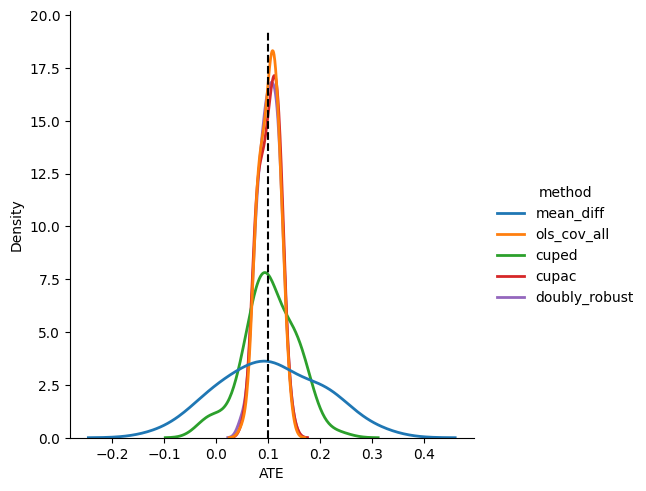

,method,mse
0,cupac,0.000381
1,cuped,0.002507
2,doubly_robust,0.000384
3,mean_diff,0.009096
4,ols_cov_all,0.000347


In [10]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))

results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'mean_diff': (np.array(ate) - REAL_ATE)**2,
    'ols_cov_all': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'cuped': (np.array(ate_cuped) - REAL_ATE)**2,
    'cupac': (np.array(ate_cupac) - REAL_ATE)**2,
    'doubly_robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=False, kind='kde', hue='method', common_norm=False, linewidth=2, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()

## Now simulating the same linear process, but using only a random variable as a covariate

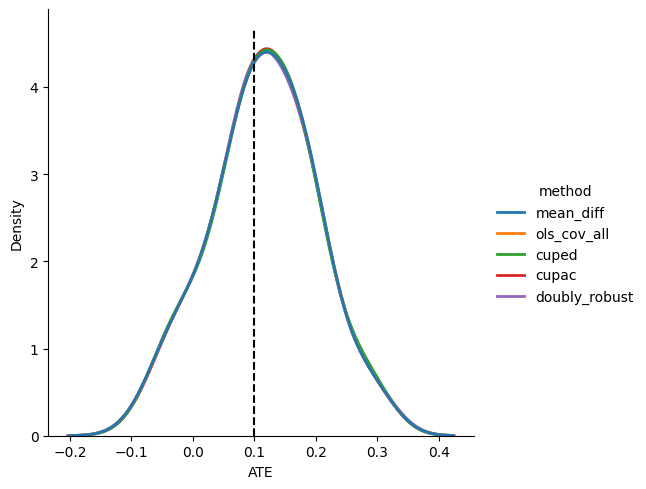

,method,mse
0,cupac,0.007105
1,cuped,0.007161
2,doubly_robust,0.007191
3,mean_diff,0.007159
4,ols_cov_all,0.007161


In [11]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['R_1']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['R_1']))
    ate_cuped.append(get_ate_cuped(analysis_data, prediction_column='R_1'))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['R_1']))

results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'mean_diff': (np.array(ate) - REAL_ATE)**2,
    'ols_cov_all': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'cuped': (np.array(ate_cuped) - REAL_ATE)**2,
    'cupac': (np.array(ate_cupac) - REAL_ATE)**2,
    'doubly_robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=False, kind='kde', hue='method', common_norm=False, linewidth=2, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()

## Simulating now with non-linear effects

$$\epsilon \sim N(0,2)$$
$$Y_0 \sim N(20,10)$$
$$X_1 \sim N(-1,-1)$$
$$X_2 \sim N(-2,1)$$
$$X_3 \sim N(5,5)$$

$$Y = Y_0 + 0.1*T + X_1 + X_2 + X_3^2 + \epsilon$$

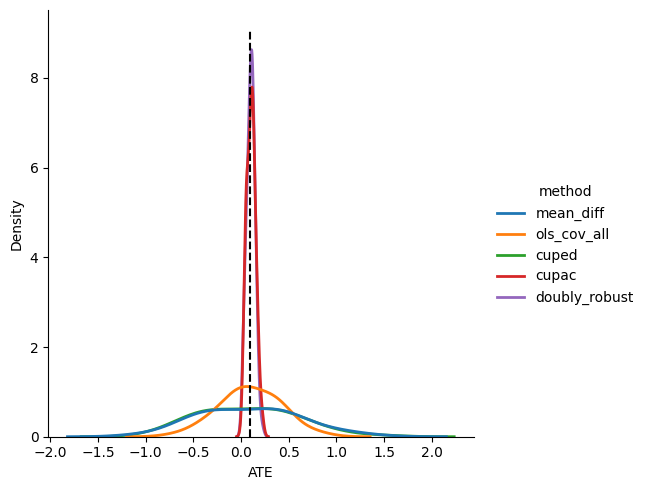

,method,mse
0,cupac,0.002041
1,cuped,0.260025
2,doubly_robust,0.001757
3,mean_diff,0.270632
4,ols_cov_all,0.100315


In [12]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
        non_linear=[False, False, True]
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))

results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'mean_diff': (np.array(ate) - REAL_ATE)**2,
    'ols_cov_all': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'cuped': (np.array(ate_cuped) - REAL_ATE)**2,
    'cupac': (np.array(ate_cupac) - REAL_ATE)**2,
    'doubly_robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=False, kind='kde', hue='method', common_norm=False, linewidth=2, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()